In [1]:
import nltk
import spacy
import string
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Input, Embedding, Reshape, Conv2D, MaxPool2D, Concatenate, Dropout, Flatten, Dense
from keras.initializers import *
from keras.regularizers import *

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

from helpers import *
from dataset import *

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(threshold=sys.maxsize)

# Download stopwords if required
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tobias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tobias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
TRAIN_MODEL = False
USE_PRETRAINED_WORD2VEC = False
MODEL_FILE = 'model.h5'

In [3]:
train_df = load_news_dataset('./data/news_train.data')#[:100000]
#train_df = load_cybertroll_dataset('./data/cybertroll_train.data')

In [4]:
CLASSNAMES = np.unique(train_df['category'])
CLASSES = len(CLASSNAMES)
train_df.head()

,id,category,headline,authors,link,short_description,date
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
print('Entries: {}'.format(len(train_df)))
print('Categories: {}'.format(CLASSES))
print(CLASSNAMES)

Entries: 200843
Categories: 41
['ARTS' 'ARTS & CULTURE' 'BLACK VOICES' 'BUSINESS' 'COLLEGE' 'COMEDY'
 'CRIME' 'CULTURE & ARTS' 'DIVORCE' 'EDUCATION' 'ENTERTAINMENT'
 'ENVIRONMENT' 'FIFTY' 'FOOD & DRINK' 'GOOD NEWS' 'GREEN' 'HEALTHY LIVING'
 'HOME & LIVING' 'IMPACT' 'LATINO VOICES' 'MEDIA' 'MONEY' 'PARENTING'
 'PARENTS' 'POLITICS' 'QUEER VOICES' 'RELIGION' 'SCIENCE' 'SPORTS' 'STYLE'
 'STYLE & BEAUTY' 'TASTE' 'TECH' 'THE WORLDPOST' 'TRAVEL' 'WEDDINGS'
 'WEIRD NEWS' 'WELLNESS' 'WOMEN' 'WORLD NEWS' 'WORLDPOST']


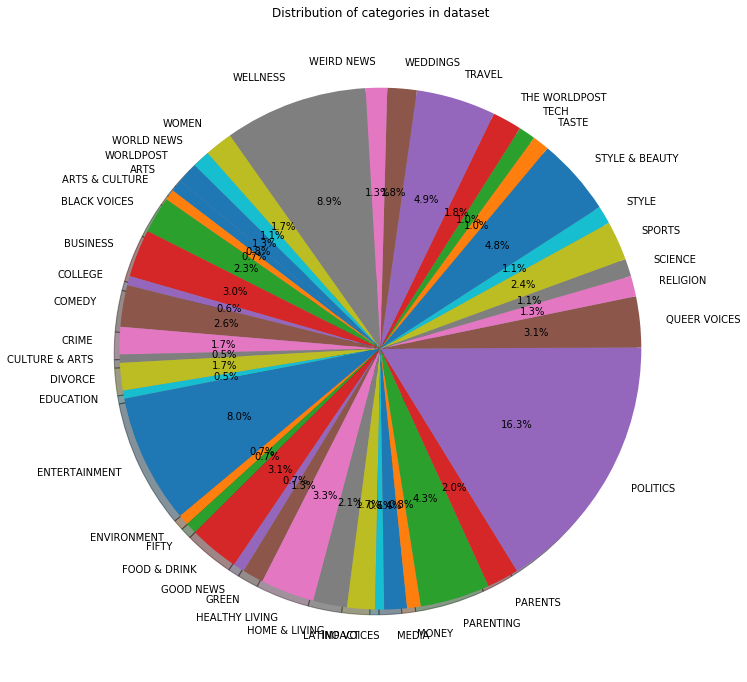

In [6]:
pie_data = []
for cn in CLASSNAMES:
    pie_data.append(train_df[train_df.category == cn].count()[0])
    
plt.figure(figsize=(15, 12))
plt.pie(pie_data, labels=CLASSNAMES, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of categories in dataset')
plt.show()

#### Keep Top k Categories

In [7]:
top_k = 10
top_k_categories = train_df['category'].value_counts()[:top_k].index.tolist()
print('Top {} categories: {}'.format(top_k, top_k_categories))

Top 10 categories: ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK', 'BUSINESS']


In [8]:
train_df = train_df[train_df['category'].isin(top_k_categories)]

In [9]:
CLASSNAMES = np.unique(train_df['category'])
CLASSES = len(CLASSNAMES)

print('Entries: {}'.format(len(train_df)))
print('Categories: {}'.format(CLASSES))
print(CLASSNAMES)

Entries: 119998
Categories: 10
['BUSINESS' 'ENTERTAINMENT' 'FOOD & DRINK' 'HEALTHY LIVING' 'PARENTING'
 'POLITICS' 'QUEER VOICES' 'STYLE & BEAUTY' 'TRAVEL' 'WELLNESS']


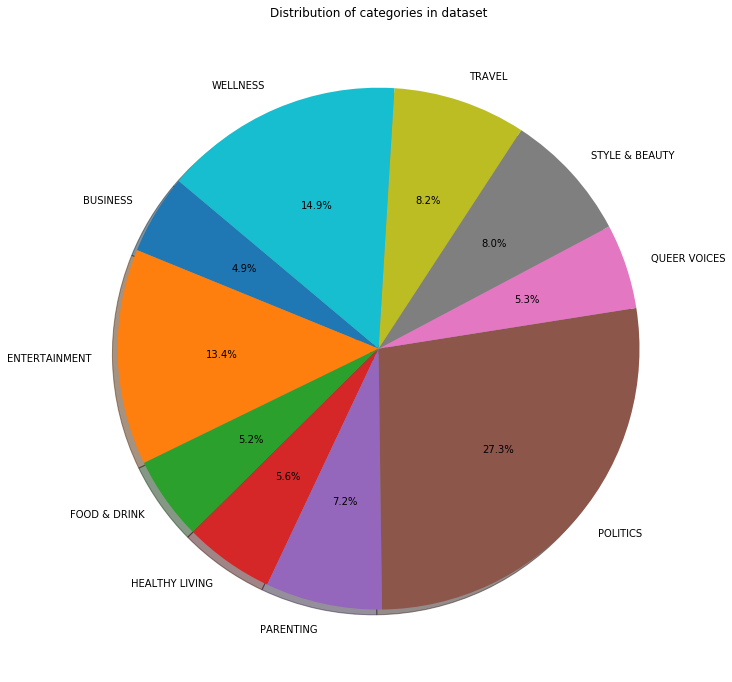

In [10]:
pie_data = []
for cn in CLASSNAMES:
    pie_data.append(train_df[train_df.category == cn].count()[0])
    
plt.figure(figsize=(15, 12))
plt.pie(pie_data, labels=CLASSNAMES, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of categories in dataset')
plt.show()

In [11]:
#495
#439 
#431
#392
test_sentence = train_df['headline'].iloc[439]
test_sentence

#for x in range(500):
#    print(x, train_df['headline'].iloc[x])

"Donald Trump Lashes Out At 'So-Called Leaks,' And Twitter Users Pounce"

In [12]:
all_words = ' '.join([text for text in train_df['headline']])
print('Number of words in all_words:', len(all_words))

Number of words in all_words: 7005582


### Wordcloud

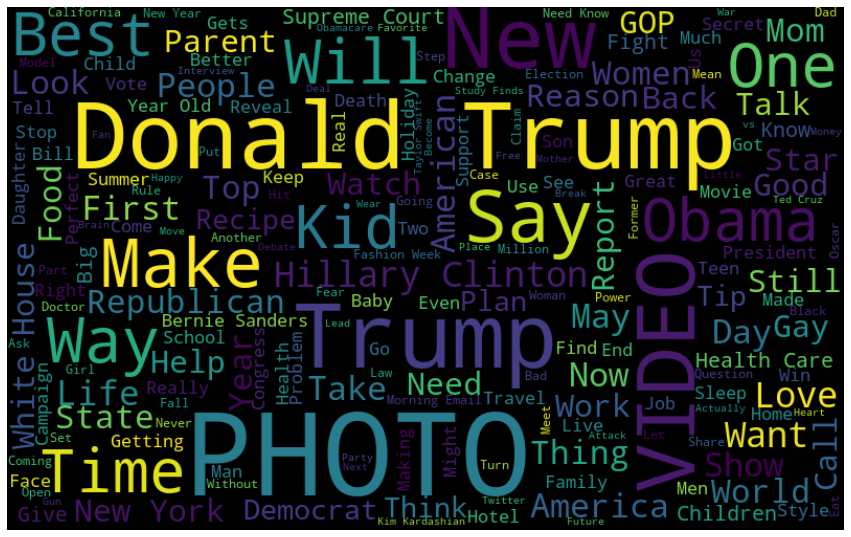

In [13]:
plot_wordcloud(train_df['headline'])

## Text Preprocessing

In [14]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
def clean_text(x, stemming=False, lemmatization=True):
    """
    clean text x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of cleaned data without stopwords, to lower, etc.
    """    
    def remove_punctuation(word):
        word = ''.join([char for char in word if char not in string.punctuation])
        return word
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer() 
    
    cleaned = []
    for text in x:
        tokens = text.split()
        tokens = [tok.lower().strip() for tok in tokens]
        
        # Remove punctuation
        tokens = [remove_punctuation(tok) for tok in tokens]
        
        # Remove numbers
        tokens = ['#num#' if tok.isnumeric() else tok for tok in tokens]
       
        # Remove Stopwords
        tokens = [tok for tok in tokens if tok not in stop_words and tok]
        
        # Stemming
        if stemming:
            tokens = [stemmer.stem(tok) for tok in tokens]
            
        if lemmatization:
            tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
        
        tokens = ' '.join(tokens)
        cleaned.append(tokens)
        
    return cleaned

In [16]:
print(test_sentence)
print(clean_text([test_sentence])[0])

cleaned_sentence = clean_text([test_sentence])

Donald Trump Lashes Out At 'So-Called Leaks,' And Twitter Users Pounce
donald trump lash socalled leak twitter user pounce


#### Create Vocabulary

In [17]:
vocabulary = np.unique(clean_text(train_df['headline']))
vocabulary_size = len(vocabulary)

In [18]:
def tokenize(x, tokenizer=None):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    if tokenizer is None:
        x_tk = Tokenizer()
        x_tk.fit_on_texts(x)
    else:
        x_tk = tokenizer

    return x_tk.texts_to_sequences(x), x_tk
    
text_tokenized, text_tokenizer = tokenize(cleaned_sentence)
print(test_sentence)
print(text_tokenizer.word_index)
print(text_tokenized)

Donald Trump Lashes Out At 'So-Called Leaks,' And Twitter Users Pounce
{'donald': 1, 'trump': 2, 'lash': 3, 'socalled': 4, 'leak': 5, 'twitter': 6, 'user': 7, 'pounce': 8}
[[1, 2, 3, 4, 5, 6, 7, 8]]


In [19]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    if length is None:
        length = max([len(sentence) for sentence in x])
        
    return pad_sequences(x, maxlen=length, padding='post', dtype='float32'), length

text_padding, _ = pad(text_tokenized, 20)
text_padding

array([[1., 2., 3., 4., 5., 6., 7., 8., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

In [20]:
def preprocess(x, tokenizer=None, padding=None):
    """
    Preprocess x
    :param x: Feature List of sentences
    :return: Tuple of (Preprocessed x, x tokenizer)
    """
    preprocess_x = clean_text(x)
    
    preprocess_x, _ = tokenize(preprocess_x, tokenizer)
    preprocess_x, pad_length = pad(preprocess_x, length=padding)    
    
    return preprocess_x, pad_length

### Train/Test split

In [21]:
X = list(train_df['headline'])
y = list(train_df['category'])

In [22]:
label_encoder = LabelEncoder()
class_labels = label_encoder.fit(CLASSNAMES)

In [23]:
MAX_FEATURES = 2000
tokenizer = Tokenizer(num_words=MAX_FEATURES, split=' ')
tokenizer.fit_on_texts(vocabulary)

In [24]:
MAX_SEQUENCE_LEN = 20
X, padding = preprocess(X, tokenizer=tokenizer, padding=MAX_SEQUENCE_LEN)
y = to_categorical(label_encoder.transform(y))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
max_words = len(X_train[0]) # length of largest sentence
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(sentence) for sentence in X])
num_classes = CLASSES

In [27]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_df['category']),
                                                 train_df['category'])
class_weights

array([2.02152965, 0.74732515, 1.92767871, 1.79288809, 1.38310281,
       0.36654041, 1.90080786, 1.24376036, 1.21381752, 0.6731628 ])

## Train Word2Vec

In [28]:
WORD_VECTOR_DIMENSION = 200

In [29]:
if USE_PRETRAINED_WORD2VEC:
    w2v_model = api.load('glove-wiki-gigaword-200')    
else:
    w2v_model = Word2Vec(size=WORD_VECTOR_DIMENSION, min_count=5)
    w2v_model.build_vocab(vocabulary)
    w2v_model.train(vocabulary, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)    

In [30]:
BATCH_SIZE = 16
EPOCHS = 20

In [31]:
embedding_matrix = np.zeros((vocabulary_size, WORD_VECTOR_DIMENSION))
for word, i in tokenizer.word_index.items():
    if i>=max_words:
        continue
    try:
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), WORD_VECTOR_DIMENSION)

del w2v_model

In [32]:
def model():
    inputs = Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')
    embedding = Embedding(input_dim=vocabulary_size, output_dim=WORD_VECTOR_DIMENSION,
                          input_length=MAX_SEQUENCE_LEN, trainable=True)(inputs)
    reshape = Reshape((MAX_SEQUENCE_LEN, WORD_VECTOR_DIMENSION, 1))(embedding)

    filter_sizes = [3,4,5]    
    xavier = glorot_normal()
    l2_reg = l2(0.004)
    
    conv_0 = Conv2D(512, kernel_size=(filter_sizes[0], WORD_VECTOR_DIMENSION), padding='valid', 
                    kernel_initializer=xavier, kernel_regularizer=l2_reg, activation='relu')(reshape)
    conv_1 = Conv2D(512, kernel_size=(filter_sizes[1], WORD_VECTOR_DIMENSION), padding='valid', 
                    kernel_initializer=xavier, kernel_regularizer=l2_reg, activation='relu')(reshape)
    conv_2 = Conv2D(512, kernel_size=(filter_sizes[2], WORD_VECTOR_DIMENSION), padding='valid', 
                    kernel_initializer=xavier, kernel_regularizer=l2_reg, activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

    dropout_0 = Dropout(0.5)(maxpool_0)
    dropout_1 = Dropout(0.5)(maxpool_1)
    dropout_2 = Dropout(0.5)(maxpool_2)    
    
    concatenated_tensor = Concatenate(axis=1)([dropout_0, dropout_1, dropout_2])
    
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(0.5)(flatten)
    output = Dense(units=num_classes, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=output)    
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=2e-4), metrics=['mse', 'accuracy'])
    
    return model

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 200)      23669800    input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 20, 200, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 18, 1, 512)   307712      reshape[0][0]                    
______________________________________________________________________________________________

In [33]:
def train():
    checkpoint = ModelCheckpoint(MODEL_FILE, verbose=1, save_best_only=True, save_weights_only=False)
    earlystopping = EarlyStopping(patience=5, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, min_delta=0.000001)
    
    logdir = './logs/' + time.strftime("%Y%m%d_%H%M%S")
    os.mkdir(logdir)
    tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_images=True, profile_batch = 100000000)    

    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2, 
                        callbacks=[checkpoint, earlystopping, tensorboard, reduce_lr],
                        class_weight=class_weights)
    
    score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
    print(score)
    
    plot_history(history)
    
if TRAIN_MODEL:
    train()
else:    
    model = load_model(MODEL_FILE)    

In [34]:
#test_sentence = 'Will Ferrell And Molly Shannon Cover The Royal Wedding As \'Cord And Tish\'' # ENTERTAINMENT # FAIL
#test_sentence = 'White House Officials Reportedly Considered Just \'Ignoring\' New Climate Research' # POLITICS # CORRECT
#test_sentence = 'Beyond the Pill: Physicians\' Trend for 2013' #WELLNESS # CORRECT
test_sentence = 'U.S. Launches Auto Import Probe, China Vows To Defend Its Interests' # BUSINESS # FAIL
#test_sentence = 'We Tasted The New Fruit Punch Oreos, So You Don\'t Have To' # FOOD & DRINK # CORRECT
#test_sentence = 'Wake-Up Calls Inspired My Change From Overdrive and Sleep Deprived' # HEALTHY_LIVING # FAIL
test_sentence = '10 Ways to De-Stress Dinnertime With Young Kids' # PARENTING # CORRECT
#test_sentence = 'Queer New World: Meet Brooklyn\'s Trey LaTrash' # QUEER VOICES # CORRECT
#test_sentence = '7 Fashion Mistakes You\'ll Regret Forever' # STYLE & BEAUTY # CORRECT
#test_sentence = 'Best Travel Apps And Hacks For Your Vacation Workout' # TRAVEL # CORRECT

preprocessed_test_sentence = preprocess([test_sentence], tokenizer, padding=MAX_SEQUENCE_LEN)[0]

print('Text: {}\n'.format(test_sentence))

prediction = model.predict(preprocessed_test_sentence)[0]
print('Prediction Value: {}'.format(np.argmax(prediction)))

prediction_argmax = np.argmax(prediction)
print("Prediction Text: {}".format(CLASSNAMES[prediction_argmax]))
prediction = (prediction*100).astype(int)

Text: 10 Ways to De-Stress Dinnertime With Young Kids

Prediction Value: 4
Prediction Text: PARENTING


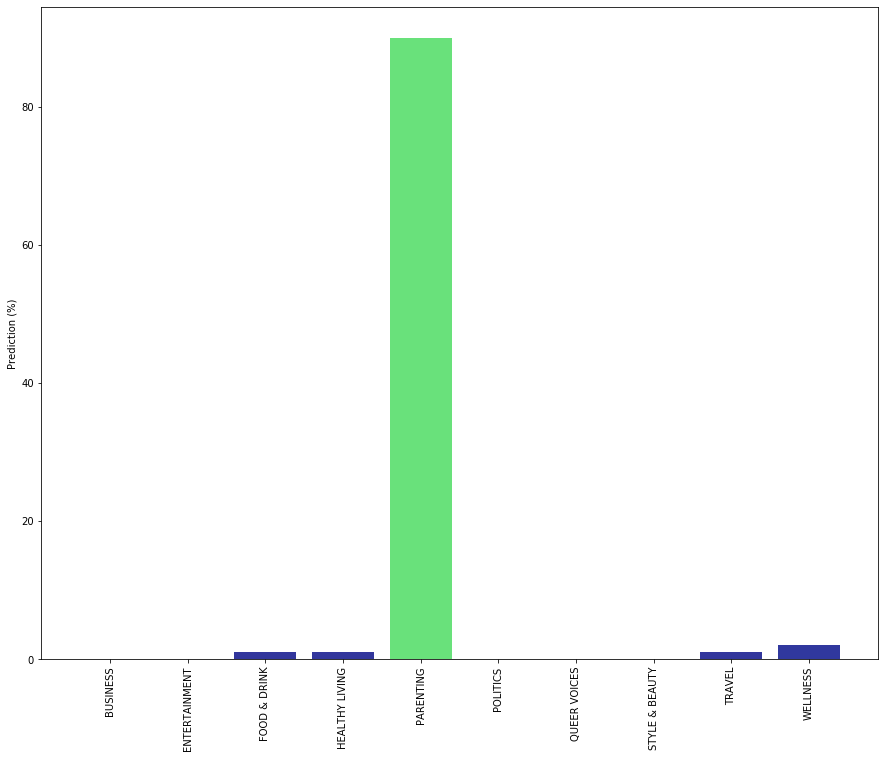

In [35]:
plot_prediction_bar(prediction, CLASSNAMES)

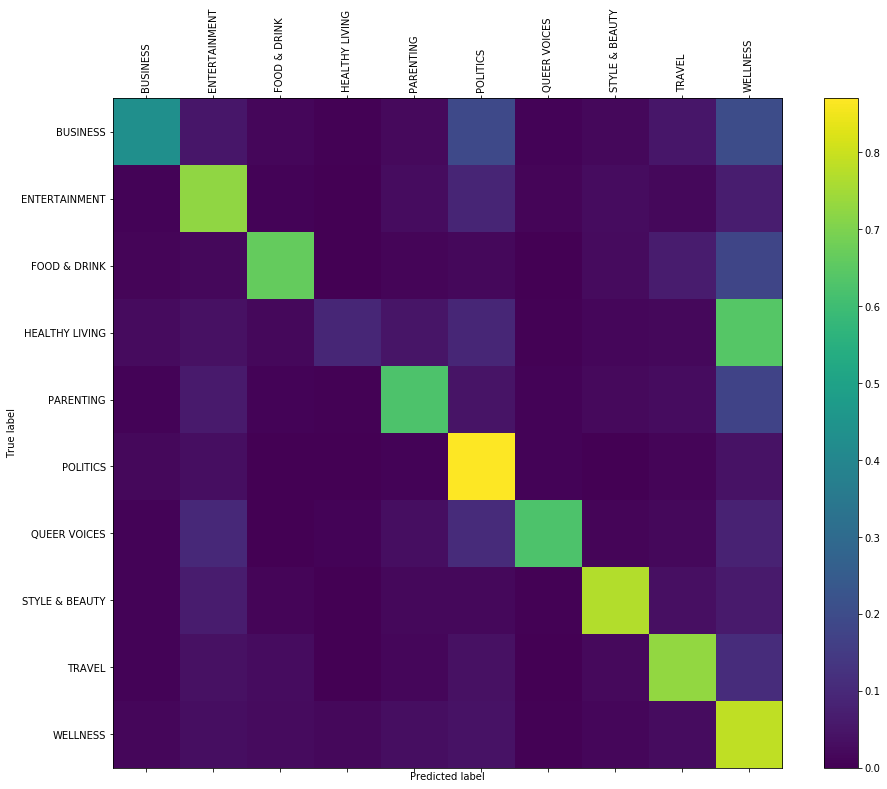

In [36]:
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, CLASSNAMES)